In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original', data_home='./')
X_, y_ = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X_[:60000], X_[60000:], y_[:60000], y_[60000:]
shuffle_index = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

## fetch 5 in MNIST datasets

In [296]:
y5_index = np.where(y_ == 5)
X5 = X_[y5_index]
X5.shape

(6313, 784)

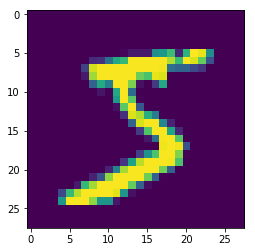

In [297]:
import matplotlib.pyplot as plt
%matplotlib inline
X5 = X5 / 255
X5_train, X5_test = X5[:5000], X5[5000:]
plt.imshow(X5[0].reshape(28, 28))

# GAN

In [280]:
tf.reset_default_graph()

In [281]:
def loss(X, batch_size):
    return tf.log(X)

## generator network

In [282]:
n_g_inputs = 28 * 28
n_g_hidden1 = 150
n_g_hidden2 = 100
n_g_outputs = n_g_inputs

In [283]:
def generate_base(n_g_inputs, batch_size, epoch, itr):
    base = tf.random_uniform(shape=(batch_size, n_g_inputs), minval=0, maxval=1, seed=epoch+itr)
    #y = tf.constant(dtype=tf.int32, shape=batch_size, value=0)
    return base

In [284]:
g_X = tf.placeholder(tf.float32, shape=(None, n_g_inputs), name='g_X')
with tf.name_scope('generator'):
    g_hidden1 = tf.layers.dense(g_X, n_g_hidden1, activation=tf.nn.leaky_relu, name='g_hidden1')
    g_hidden2 = tf.layers.dense(g_hidden1, n_g_hidden2, activation=tf.nn.leaky_relu, name='g_hidden2')
    g_output = tf.layers.dense(g_hidden2, n_g_outputs, activation=tf.nn.leaky_relu, name='g_output')

#with tf.name_scope('g_loss'):
    

## discriminator network

In [285]:
n_d_inputs = 28*28
n_d_hidden1 = 75
n_d_hidden2 = 75
n_d_output = 2

In [286]:
def minibatch(X, batch_size):
    index = np.random.randint(0, len(X), batch_size)
    X_batch = X[index]
    #y = tf.constant(dtype=tf.int32,shape=batch_size, value=1)
    return X_batch

In [287]:
def return_y(batch_size):
    y0 = np.zeros(batch_size)
    y1 = np.ones(batch_size)
    y = np.r_[y0, y1]
    return tf.constant(y, dtype=tf.int32)

In [288]:
d_X = tf.placeholder(tf.float32, shape=(None, n_d_inputs), name='d_X')
d_y = tf.placeholder(tf.float32, shape=(None), name='d_y')
n_batchies = tf.placeholder(tf.int32, shape=(None), name='n_batchies')
with tf.name_scope('discriminator'):
    d_hidden1 = tf.layers.dense(d_X, n_d_hidden1, activation=tf.nn.relu, name='d_hidden1')
    d_hidden2 = tf.layers.dense(d_hidden1, n_d_hidden2, activation=tf.nn.relu, name='d_hidden2')
    d_output = tf.layers.dense(d_hidden2, n_d_output, name='d_output')
    #d_sigmoid = tf.sigmoid(d_output)

with tf.name_scope('loss'):
    #softmax = tf.nn.softmax(logits=d_output)
    #y0 = tf.slice(softmax, begin=(0, 0), size=(n_batchies, -1))
    #y1 = tf.slice(softmax, begin=(n_batchies, 0), size=(n_batchies, -1))
    #d_loss = -tf.reduce_mean(tf.log(y1) + tf.log(1 - y0))
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=d_output, labels=tf.cast(d_y, tf.int32))
    d_loss = tf.reduce_mean(xentropy)
with tf.name_scope('train'):
    d_optimizer = tf.train.AdamOptimizer()
    d_training_op = d_optimizer.minimize(d_loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(d_output, tf.cast(d_y, tf.int32), 1)
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))

In [289]:
init = tf.global_variables_initializer()

In [299]:
n_epochs = 10
batch_size = 20
test_batch_size = 1000

In [301]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for itr in range(10):
            #Generatorから生成した画像
            noise_seed = generate_base(n_g_inputs, batch_size, epoch, itr)
            noise = noise_seed.eval()
            X0 = g_output.eval(feed_dict={g_X: noise})
            #MNISTの画像
            X1 = tf.cast(minibatch(X5_train, batch_size), tf.float32).eval()
            #テンソルの結合
            X_concat = tf.concat([X0, X1], 0).eval()
            y_concat = return_y(batch_size).eval()
            shuffle_idx = np.random.randint(0, batch_size, batch_size * 2)
            X_concat_sh, y_concat_sh = X_concat[shuffle_idx, :], y_concat[shuffle_idx]
            sess.run(d_training_op, feed_dict={d_X: X_concat_sh, n_batchies: batch_size, d_y: y_concat_sh})
            if itr % 50 == 0:
                noise_test = generate_base(n_g_inputs, test_batch_size, epoch, itr).eval()
                X0_test = g_output.eval(feed_dict={g_X: noise_test})
                X1_test = tf.cast(minibatch(X5_test, test_batch_size), tf.float32).eval()
                X_test_concat = tf.concat([X0_test, X1_test], 0).eval()
                y_test_concat = return_y(test_batch_size).eval()
                print(correct.eval(feed_dict={d_X: X_test_concat, d_y: y_test_concat}))
                accuracy = acc.eval(feed_dict={d_X: X_test_concat, d_y: y_test_concat})
                print(accuracy)


[ True  True  True ... False False False]
0.501
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5
[ True  True  True ... False False False]
0.5


MNISTのほうが分類できてないっぽい